# Predicting Bike Rentals in Washington DC

Many American cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

Hadi Fanaee-T at the University of Porto compiled this data into a CSV file, which we'll be working with in this project. The file contains 17380 rows, with each row representing the number of bike rentals for a single hour of a single day. We can download the data from the [University of California, Irvine's website](http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset).

Here are the descriptions for the relevant columns:

   - **`instant`**  - A unique sequential ID number for each row
   - **`dteday`** - The date of the rentals
   - **`season`** - The season in which the rentals occurred
   - **`yr`** - The year the rentals occurred
   - **`mnth`** - The month the rentals occurred
   - **`hr`** - The hour the rentals occurred
   - **`holiday`** - Whether or not the day was a holiday
   - **`weekday`** - The day of the week (as a number, 0 to 7)
   - **`workingday`** - Whether or not the day was a working day
   - **`weathersit`** - The weather (as a categorical variable)
   - **`temp`** - The temperature, on a 0-1 scale
   - **`atemp`** - The adjusted temperature
   - **`hum`** - The humidity, on a 0-1 scale
   - **`windspeed`** - The wind speed, on a 0-1 scale
   - **`casual`** - The number of casual riders (people who hadn't previously signed up with the bike sharing program)
   - **`registered`** - The number of registered riders (people who had already signed up)
   - **`cnt`** - The total number of bike rentals (casual + registered)
   
In this project, we'll try to predict the total number of bikes people rented in a given hour. We'll predict the cnt column using all of the other columns, except for casual and registered. To accomplish this, we'll create a few different machine learning models and evaluate their performance.


We will start off by reading the **`bike_rental_hour.csv`** to a dataframe using pandas

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import numpy
%matplotlib inline

#global variables 
test= None
train = None
mses = {}
features= None
target = None
bike_rentals = None
bike_rentals_file_name = "bike_rental_hour.csv"


In [2]:
bike_rentals = pd.read_csv(bike_rentals_file_name)

## Data exploration

Lets print out few rows from the data and then check bike rental patterns by looking at the distribution of total rentals. We will also look at the correlation each column has with our target column **`cnt`**

In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


(array([6972., 3705., 2659., 1660.,  987.,  663.,  369.,  188.,  139.,
          37.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

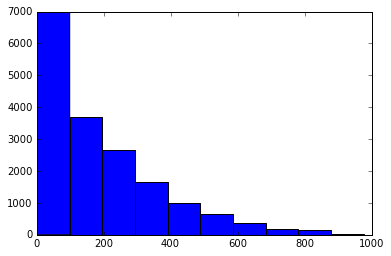

In [4]:
plt.hist(bike_rentals["cnt"])

In [5]:
corr= bike_rentals.corr()
corr

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.404046,0.866014,0.489164,-0.004775,0.014723,0.001357,-0.003416,-0.014198,0.136178,0.137615,0.009577,-0.074505,0.158295,0.282046,0.278379
season,0.404046,1.000000,-0.010742,0.830386,-0.006117,-0.009585,-0.002335,0.013743,-0.014524,0.312025,0.319380,0.150625,-0.149773,0.120206,0.174226,0.178056
yr,0.866014,-0.010742,1.000000,-0.010473,-0.003867,0.006692,-0.004485,-0.002196,-0.019157,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684,0.250495
mnth,0.489164,0.830386,-0.010473,1.000000,-0.005772,0.018430,0.010400,-0.003477,0.005400,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273,0.120638
hr,-0.004775,-0.006117,-0.003867,-0.005772,1.000000,0.000479,-0.003498,0.002285,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141,0.394071
holiday,0.014723,-0.009585,0.006692,0.018430,0.000479,1.000000,-0.102088,-0.252471,-0.017036,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345,-0.030927
weekday,0.001357,-0.002335,-0.004485,0.010400,-0.003498,-0.102088,1.000000,0.035955,0.003311,-0.001795,-0.008821,-0.037158,0.011502,0.032721,0.021578,0.026900
workingday,-0.003416,0.013743,-0.002196,-0.003477,0.002285,-0.252471,0.035955,1.000000,0.044672,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326,0.030284
weathersit,-0.014198,-0.014524,-0.019157,0.005400,-0.020203,-0.017036,0.003311,0.044672,1.000000,-0.102640,-0.105563,0.418130,0.026226,-0.152628,-0.120966,-0.142426
temp,0.136178,0.312025,0.040913,0.201691,0.137603,-0.027340,-0.001795,0.055390,-0.102640,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361,0.404772


In [6]:
corr["cnt"].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

Clearly, the columns **`registered`**, **`casual`**, **`temp`**, **`atemp`**, **`hr`**, **`instant`** and **`yr`** have higher coreleation than remaining columns. **`registered`**, **`casual`**, **`temp`** and **`hr`** are the top four columns 

It can often be helpful to calculate features before applying machine learning models. Features can enhance the accuracy of models by introducing new information, or distilling existing information.

For example, the hr column in bike_rentals contains the hours during which bikes are rented, from 1 to 24. A machine will treat each hour differently, without understanding that certain hours are related. We can introduce some order into the process by creating a new column with labels for morning, afternoon, evening, and night. This will bundle similar times together, enabling the model to make better decisions.

Instead of strings "morning", "afternoon", etc, we will use digitals so that it is easier to manipulate

In [7]:
def assign_label(hour):
    if hour >=0 and hour < 6:
        return 4
    elif hour >=6 and hour < 12:
        return 1
    elif hour >= 12 and hour < 18:
        return 2
    elif hour >= 18 and hour <=24:
        return 3

In [8]:
bike_rentals["time_label"] = bike_rentals["hr"].apply(assign_label)

In [9]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Split data set into train and test datasets

Before we can begin applying machine learning algorithms, we'll need to split the data into training and testing sets. This will enable us to train an algorithm using the training set, and evaluate its accuracy on the testing set. If we train an algorithm on the training data, then evaluate its performance on the same data, we can get an unrealistically low error value, due to overfitting. This is basically because the model learns what output is desiered as it was already fed the desiered output while training. 

In this  project we will split the dataset into 80% and 20% buckets. 80% being training data nad 20% test data




In [10]:
def get_train_test_df(df):
    # lets sample 80% of data for training
    train = df.sample(frac=.8)
    # remaining data, the data which is not part of train, becomes test data
    test = df.loc[~df.index.isin(train.index)]
    return train, test

## Error Metric

Based on our above data exploration, mean squared error(MSE) metric makes the most sesne to evaluate model predictions. MSE works on continious numeric data and our cnt column is continious and numeric

## Machine learning models

First we will define our feature and target columns. Target column is **`cnt`**. From the remaining columns we will remove columns which are not relavent and which those which provides answers to the model like **`cnt`**, **`casual`**, **`registered`** and **`dteday`**. The remaining columns becomes our feature columns

In [11]:
def get_features_and_target(df):
    features = list(train.columns)
    #target is cnt column
    target = "cnt"
    #lets remove target column from list of features used to train the model
    features.remove(target)
    features.remove("casual")
    features.remove("registered")
    features.remove("dteday")
    return features, target

### LinearRegression model
Now we are ready to model. Lets start by using **`LinearRegression`** model. We will fit, predict and evaluate our model. Linear regression will probably work fairly well on this data, given that many of the columns are highly correlated with **`cnt`**

Linear regression works best when predictors are linearly correlated to the target and also independent -- in other words, they don't change meaning when we combine them with each other. The good thing about linear regression is that it's fairly resistant to overfitting because it's straightforward. It also can be prone to underfitting the data, however, and not building a powerful enough model. This means that linear regression usually isn't the most accurate option

In [12]:
def model_lr(train, test, features, target):
    lr = LinearRegression()
    lr.fit(train[features], train[target])
    predictions = lr.predict(test[features])
    mse = numpy.mean((predictions-test[target])**2)
    return mse
    

In [13]:
train, test = get_train_test_df(bike_rentals)
features, target = get_features_and_target(bike_rentals)
mses["LinearRegression"] = model_lr(train, test, features, target)

print("mse using LinearRegression = {:0.2f}".format(mses["LinearRegression"]))

mse using LinearRegression = 17426.21


The error is very high as the **`cnt`** column contains few values which are relatively high compared to all other values. Few high values always have a distorted impact on mean, mean squared values. We can check this by looking at ratio of number of rows with cnt value equal or more than 50 to number of rows with rental less than 50

In [14]:
def check_high_values(df, high_value):
    cnt_frequencey = df["cnt"].value_counts()
    high_rental = cnt_frequencey[cnt_frequencey >= high_value].count()
    high_rental_sum = cnt_frequencey[cnt_frequencey >= high_value].sum()
    low_rental =  cnt_frequencey[cnt_frequencey < high_value].count()
    low_rental_sum = cnt_frequencey[cnt_frequencey < high_value].sum()
    total = cnt_frequencey.sum()
    high_to_low = high_rental/low_rental*100
    print("% of high renters to low renters (< {} hours) = {:0.2f}".format(high_value, high_to_low))
    print()
    print("""high renters who make up only {:0.2f} % have rented {:0.2f}% of total hours amounting to {:0.2f} hours. Low renters who make up {:0.2f}  have rented {:0.2f} hours which is {:0.2f}% of total rentals""".format(high_to_low, 
                                                high_rental_sum/total * 100,
                                                high_rental_sum, 
                                                (100 - high_to_low),
                                                low_rental_sum,
                                                low_rental_sum/total * 100))

In [15]:
check_high_values(bike_rentals, 50)

% of high renters to low renters (< 50 hours) = 7.15

high renters who make up only 7.15 % have rented 30.73% of total hours amounting to 5340.00 hours. Low renters who make up 92.85  have rented 12039.00 hours which is 69.27% of total rentals


Clearly the above analysis shows that a small number of renters who make up around 7% are retning nearly 30% of all the rental hours



### DecisionTreeRegressor model

Fitting a linear regression model to features where extreme values distort the linearity is not a good idea. Lets try DecisionTreeRegressor model. This model will take into account non-linear features and predictors

Decision trees tend to predict outcomes much more reliably than linear regression models. Because a decision tree is a fairly complex model, it also tends to overfit, particularly when we don't tweak parameters like maximum depth and minimum number of samples per leaf. Decision trees are also prone to instability -- small changes in the input data can result in a very different output model.

To avoid overfitting, we will restrict the min_samples_leaf to 5

In [16]:
def model_dtr(train, test, features, target):
    dtr = DecisionTreeRegressor(min_samples_leaf=5)
    dtr.fit(train[features], train[target])    
    predictions = dtr.predict(test[features])
    mse = numpy.mean((predictions - test[target]) ** 2)
    return mse   
    

In [17]:
mses["DecisionTreeRegressor"] = model_dtr(train, test, features, target)
print("mse using DecisionTreeRegressor = {:0.2f}".format(mses["DecisionTreeRegressor"]))

mse using DecisionTreeRegressor = 2749.33


## RandomForestRegressor

We can now apply the random forest algorithm, which improves on the decision tree algorithm. Random forests tend to be much more accurate than simple models like linear regression. Due to the way random forests are constructed, they tend to overfit much less than decision trees. Random forests can still be prone to overfitting, though, so it's important to tune parameters like maximum depth and minimum samples per leaf


In [18]:
def model_rfr(train, test, features, target):
    rfr = RandomForestRegressor()
    rfr.fit(train[features], train[target])
    predictions = rfr.predict(test[features])
    mse = numpy.mean((predictions-test[target])**2)
    return mse

In [19]:
mses["RandomForestRegressor"] = model_rfr(train, test, features, target)
print("mse using RandomForestRegressor = {:0.2f}".format(mses["RandomForestRegressor"]))

mse using RandomForestRegressor = 1939.78


In [20]:
mses_value_series = pd.Series(mses, index=mses.keys()).sort_values()
print(mses_value_series) 

RandomForestRegressor     1939.781226
DecisionTreeRegressor     2749.332577
LinearRegression         17426.208674
dtype: float64


# Conclusion

RandomForestRegressor has clearly improved the prediction accuracy by nearly factor of ten. 
